# Rendu Final Projet Fairness en IA

Étudiant 01 : MEDJADJ Mohamed Abderraouf <br>
Étudiant 02 : KERMADJ Zineddine <br>
Groupe : 01 <br>
Parcours : LDD3 Magistère d'Informatique

---

## I. Introduction

### a. Objectif du projet :
L’objectif de ce projet est d’**analyser un sous-ensemble de métadonnées et d’images** du NIH Chest X-ray Dataset, comprenant environ 5300 points de données, afin d’**identifier d’éventuels biais**. Après avoir appliqué une méthode de prétraitement pour **réduire ces biais et améliorer l’équité des données**, nous entraînerons un **modèle de classification d’images**. Enfin, nous analyserons **l’impact de la pondération sur les performances du modèle** ainsi que **l’effet du post-traitement** sur l’atténuation des biais.
### b. Description du dataset :
*Le NIH Chest X-ray Dataset est un vaste ensemble de données médicales comprenant **112 120 images** de radiographies thoraciques issues de **30 805 patients uniques**, avec des étiquettes de maladies générées par traitement automatique du langage naturel (**NLP**) à partir des rapports radiologiques. Ce jeu de données vise à pallier le **manque d’images médicales annotées**, un obstacle majeur au développement de systèmes de diagnostic assisté par ordinateur (CAD) cliniquement pertinents. Les étiquettes sont estimées à plus de **90 % de précision**, rendant cet ensemble adapté à l’apprentissage faiblement supervisé. Avant sa publication, le plus grand jeu de données disponible comptait seulement 4 143 images. Plus de détails sur l’ensemble de données et le processus d’annotation sont disponibles dans l’article en libre accès : « ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases » (Wang et al.).*
### c. Contenu du dataset :
***Image Index** : Identifiant unique pour chaque image. <br>
**Finding Labels** : Diagnostiques associés à l'image (plusieurs diagnostics peuvent être présents). <br>
**Follow-up** # : Le numéro de suivi, indiquant si l'image appartient à un suivi ou à une première consultation. <br>
**Patient ID** : Identifiant unique pour chaque patient. <br>
**Patient Age** : L'âge du patient. <br>
**Patient Gender** : Le genre du patient. <br>
**View Position** : La position de l'image (par exemple, AP pour antéro-postérieur). <br>
**Dimensions et espacements de l'image** : Ces informations peuvent être utiles pour l'analyse des images, mais elles ne semblent pas directement liées à l'identification des biais.*

### SOMMAIRE:
<pre><b>
I.   Introduction
II.    0. Fonctions Utilitaires
II.    1. Préparation des données
II.    2. Analyse des données
II.    3. Identification des biais
III. Application des méthodes de preprocessing
IV.  Application des méthodes de postprocessing
V.   Analyse et compréhension
VI.  Conclusion
</b></pre>

---
# **REMARQUES IMPORTANTES:**
### *a. Les explications des sorties, commentaires des graphiques, etc, sont inclus dans des cellules de **code, et pas markdown**, veuillez donc s'il vous plaît ne pas ignorer les lignes commentées.*

### *b. Pour l'entrainement, veuillez consulter "training.ipynb".*
---

## II.0. Fonctions utilitaires

### a. Import des librairies nécessaires

In [1]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.metrics import confusion_matrix
from aif360.datasets import BinaryLabelDataset
from aif360.sklearn.metrics import *
from aif360.algorithms.preprocessing import *
from train_classifieur import train_classifier, pred_classifier
from scipy.sparse import csr_matrix

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'
pip install 'aif360[OptimalTransport]'


### b. Les fonctions utilitaires

In [2]:
# Fonction pour le calcul des métriques de fairness

def get_group_metrics(
    y_true,
    y_pred=None,
    prot_attr=None,
    priv_group=1,
    pos_label=1,
    sample_weight=None,
):
    group_metrics = {}
    group_metrics["base_rate"] = base_rate(
        y_true=y_true, pos_label=pos_label, sample_weight=sample_weight
    )
    group_metrics["statistical_parity_difference"] = statistical_parity_difference(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
    )
    group_metrics["disparate_impact_ratio"] = disparate_impact_ratio(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
    )
    if not y_pred is None:
        group_metrics["equal_opportunity_difference"] = equal_opportunity_difference(
            y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["average_odds_difference"] = average_odds_difference(
            y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, priv_group=priv_group, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["conditional_demographic_disparity"] = conditional_demographic_disparity(
            y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["smoothed_edf"] = smoothed_edf(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, pos_label=pos_label, sample_weight=sample_weight
        )
        group_metrics["df_bias_amplification"] = df_bias_amplification(
        y_true=y_true, y_pred=y_pred, prot_attr=prot_attr, pos_label=pos_label, sample_weight=sample_weight
        )
    return group_metrics

In [3]:
# Fonction pour tracer des matrices de confusion

def plot_confusion_matrix(y_true, y_pred, labels=["sain", "malade"], normalize=False, title="Matrice de confusion"):
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / len(y_true) * 100
    
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    
    fig = px.imshow(cm_df, 
                    labels=dict(x="Prédiction", y="Vérité", color="Fréquence (%)" if normalize else "Fréquence"), 
                    x=labels, 
                    y=labels, 
                    color_continuous_scale='Blues',
                    range_color=[0, 100] if normalize else None) 
    
    for i in range(len(cm_df)):
        for j in range(len(cm_df.columns)):
            fig.add_annotation(
                x=j,
                y=i,
                text=f'{cm_df.iloc[i, j]:.2f}%' if normalize else f'{cm_df.iloc[i, j]}',
                showarrow=False,
                font=dict(color="black", size=14),
                align="center"
            )
    
    fig.update_layout(title=title, xaxis_title="Prédiction", yaxis_title="Vérité")
    fig.show()

In [4]:
# Fonction pour afficher des matrices de confusion séparées pour chaque groupe défini par group_columns
def plot_confusion_matrix_by_group(y_true, y_pred, df, group_columns, labels=None, normalize=False):
    for group_value, group_df in df.groupby(group_columns):
        y_true_group = y_true[group_df.index]
        y_pred_group = y_pred[group_df.index]
        
        print(f"Matrice de confusion pour {group_columns}: {group_value}")
        plot_confusion_matrix(y_true_group, y_pred_group, labels, normalize, title=f"Matrice de Confusion ({group_columns}={group_value})")


## II.1. Preparation des données

### a. Chargement du dataset

In [5]:
DATA_DIR = "./DATA"
PREDS_DIR = "./expe_log"
df = pd.read_csv(PREDS_DIR+"/preds.csv")

### b. Exploration préliminaire

In [6]:
print(df.shape)
# Affichons les 5 premiers points de donnée du dataset
df.head()

(5310, 14)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],WEIGHTS,preds,labels
0,00000028_000.png,Pleural_Thickening,0,28,63,M,PA,2048,2500,0.168000,0.168000,1,sain,malade
1,00000037_000.png,No Finding,0,37,72,M,PA,2708,2638,0.143000,0.143000,1,sain,sain
2,00000044_000.png,Consolidation|Effusion|Infiltration,0,44,79,M,PA,2010,2021,0.194311,0.194311,1,malade,malade
3,00000044_001.png,Infiltration|Pleural_Thickening,1,44,78,M,PA,2544,3056,0.139000,0.139000,1,malade,malade
4,00000044_002.png,Cardiomegaly,2,44,78,M,PA,3056,2544,0.139000,0.139000,1,malade,malade


In [7]:
# Vérifions les types de données et les valeurs manquantes
df.info()

# Explication des sorties:
# Le dataset est composé de 12 colonnes, dont 8 correspondent à des features numériques, et 4 catégorielles.
# Toutes les colonnes ne contiennent pas de valeurs nulles sauf la dernière (Unnamed: 11), qui contient que des valeurs nulles.
# Le dataset contient 54009 points de données.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5310 entries, 0 to 5309
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  5310 non-null   object 
 1   Finding Labels               5310 non-null   object 
 2   Follow-up #                  5310 non-null   int64  
 3   Patient ID                   5310 non-null   int64  
 4   Patient Age                  5310 non-null   int64  
 5   Patient Gender               5310 non-null   object 
 6   View Position                5310 non-null   object 
 7   OriginalImage[Width          5310 non-null   int64  
 8   Height]                      5310 non-null   int64  
 9   OriginalImagePixelSpacing[x  5310 non-null   float64
 10  y]                           5310 non-null   float64
 11  WEIGHTS                      5310 non-null   int64  
 12  preds                        5310 non-null   object 
 13  labels            

In [8]:
# Statistiques descriptives
df.describe()

# Explication des sorties:
# Max: On remarque qu'il y a une valeur max = 412 pour l'age, qui n'est pas normal (outlier), et qui peut être dû à une erreur de frappe.
# Count = nombre de points de données sauf pour 'Unnamed: 11', cette colonne contient que des null.
# Mean: Moyenne des valeurs par colonne, pas de remarque importante.
# Std: Standard deviation des valeurs par colonne, pas de remarque importante.
# Min: Le min des valeurs par colonne, pas de remarque importante.
# Les Quantiles: pas de remarque importante.

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],WEIGHTS
count,5310.000000,5310.000000,5310.000000,5310.000000,5310.000000,5310.000000,5310.000000,5310.0
mean,7.649153,13907.216573,45.682298,2649.781921,2493.101695,0.155413,0.155413,1.0
std,12.385238,8621.954510,16.703801,344.656929,402.553988,0.016414,0.016414,0.0
min,0.000000,28.000000,1.000000,1282.000000,1153.000000,0.115000,0.115000,1.0
25%,0.000000,6492.000000,34.000000,2500.000000,2048.000000,0.143000,0.143000,1.0
50%,3.000000,13214.000000,47.000000,2544.000000,2544.000000,0.143000,0.143000,1.0
75%,9.000000,20585.000000,57.000000,2992.000000,2991.000000,0.168000,0.168000,1.0
max,80.000000,30793.000000,150.000000,3056.000000,3056.000000,0.194323,0.194323,1.0


### c. Préparation du dataset

In [9]:
# On sauvegarde le dataframe original avant toute transformation
original_df = df.copy()

In [10]:
# Fonction pour faire des train-test split:

def train_test_split(df):
    train_sain_path = DATA_DIR+"/train/sain"
    train_malade_path = DATA_DIR+"/train/malade"

    train_images = set(os.listdir(train_sain_path) + os.listdir(train_malade_path))

    df["in_train"] = df["Image Index"].apply(lambda x: 1 if x in train_images else 0)

In [11]:
# Élimination des outliers (age > 130 years old)
df = df[df['Patient Age'] <= 130]

# Séparation des données train-test
train_test_split(df)

# Séparation des colonnes liées aux images des autres métadonnées
df_image_related = df[['Image Index', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'View Position']]
df_others = df.drop(columns=['Image Index', 
    'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'View Position'])

# Encodage de 'preds' et 'labels' en binaire
df_others["preds"] = df_others["preds"].map({"sain": 0, "malade": 1}) 
df_others["labels"] = df_others["labels"].map({"sain": 0, "malade": 1})

# Déplacement du label 'Finding Labels' à la fin du dataframe.
df_others = df_others[[col for col in df_others.columns if col != 'Finding Labels'] + ['Finding Labels']]
df_original_label = df_others[['Finding Labels']]

print(df_others.shape)
# On remarque que le nombre de points de données a diminué de 6 (outliers eliminés).

df_others.head()

(5309, 9)


,Follow-up #,Patient ID,Patient Age,Patient Gender,WEIGHTS,preds,labels,in_train,Finding Labels
0,0,28,63,M,1,0,1,0,Pleural_Thickening
1,0,37,72,M,1,0,0,1,No Finding
2,0,44,79,M,1,1,1,1,Consolidation|Effusion|Infiltration
3,1,44,78,M,1,1,1,1,Infiltration|Pleural_Thickening
4,2,44,78,M,1,1,1,1,Cardiomegaly


In [12]:
# VERSION 1: encodage one-hot du label

# a. Création d'une colonne 'Finding Labels' contenant une liste des labels
df_encoded_OH = df_others.copy()
df_encoded_OH['Finding Labels'] = df_encoded_OH['Finding Labels'].replace('No Finding', '').str.split('|')
df_encoded_OH['Finding Labels'] = df_encoded_OH['Finding Labels'].apply(lambda x: [] if x == [''] else x)

# b. Encodage des colonnes en One-Hot avec le prefix "Finding_"
all_labels = set([label for sublist in df_encoded_OH['Finding Labels'] for label in sublist])
for label in all_labels:
    column_name = f"Finding_{label.lower().replace(' ', '_')}"
    df_encoded_OH[column_name] = df_encoded_OH['Finding Labels'].apply(lambda x: 1 if label in x else 0)
df_encoded_OH = df_encoded_OH.drop(columns=['Finding Labels'])

df_encoded_OH

,Follow-up #,Patient ID,Patient Age,Patient Gender,WEIGHTS,preds,labels,in_train,Finding_mass,Finding_nodule,...,Finding_consolidation,Finding_emphysema,Finding_effusion,Finding_pleural_thickening,Finding_hernia,Finding_atelectasis,Finding_pneumonia,Finding_cardiomegaly,Finding_pneumothorax,Finding_infiltration
0,0,28,63,M,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,37,72,M,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,44,79,M,1,1,1,1,0,0,...,1,0,1,0,0,0,0,0,0,1
3,1,44,78,M,1,1,1,1,0,0,...,0,0,0,1,0,0,0,0,0,1
4,2,44,78,M,1,1,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5305,0,30739,38,F,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5306,0,30745,56,M,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5307,0,30748,59,M,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5308,0,30775,20,M,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# VERSION 2: encodage binaire (1 ssi patient malade) du label

df_encoded_bool = df_others.copy()
df_encoded_bool = df_encoded_bool.drop(columns=['Finding Labels'])

df_encoded_bool

,Follow-up #,Patient ID,Patient Age,Patient Gender,WEIGHTS,preds,labels,in_train
0,0,28,63,M,1,0,1,0
1,0,37,72,M,1,0,0,1
2,0,44,79,M,1,1,1,1
3,1,44,78,M,1,1,1,1
4,2,44,78,M,1,1,1,1
...,...,...,...,...,...,...,...,...
5305,0,30739,38,F,1,0,0,0
5306,0,30745,56,M,1,0,0,1
5307,0,30748,59,M,1,0,0,1
5308,0,30775,20,M,1,0,0,1


## II.2. Analyse des données

### 0. Séparation du label, des features numériques et catégorielles

In [14]:
df_encoded = df_encoded_OH
df_encoded.dtypes
# Toutes les features sont numériques, sauf le genre (sexe)

Follow-up #                    int64
Patient ID                     int64
Patient Age                    int64
Patient Gender                object
WEIGHTS                        int64
preds                          int64
labels                         int64
in_train                       int64
Finding_mass                   int64
Finding_nodule                 int64
Finding_fibrosis               int64
Finding_edema                  int64
Finding_consolidation          int64
Finding_emphysema              int64
Finding_effusion               int64
Finding_pleural_thickening     int64
Finding_hernia                 int64
Finding_atelectasis            int64
Finding_pneumonia              int64
Finding_cardiomegaly           int64
Finding_pneumothorax           int64
Finding_infiltration           int64
dtype: object

In [15]:
# Séparation du label, des features numériques et catégorielles
one_hot_label = [col for col in df_encoded.columns if col.startswith("Finding")] # pour la version 1 de l'encodage
boolean_label = 'labels' # pour la version 2 de l'encodage

numerical_features = list(set(df_encoded.select_dtypes(include=np.number).columns) - set(one_hot_label))
categorical_features = list(set(df_encoded.columns) - set(numerical_features) - set(one_hot_label))

### Analyse univariée

### a. Analyse de la corrélation (Feature-Label et Feature-Feature)

In [16]:
# Fonction qui calcule la corrélation linéaire entre deux features
def compute_correlation(df, cola, colb):
  return np.corrcoef(df[cola].values, df[colb].values)[0][1]

In [17]:
# Calcul des corrélations entre les features et les colonnes du label (one-hot) (Feature-Label).
for num_feature in numerical_features:
  if num_feature not in {"labels", "preds", "in_train"}:
    for label_col in one_hot_label:
      corr = compute_correlation(df_encoded, label_col, num_feature)
      if np.abs(corr) > 0.05 :
        print(num_feature, label_col, corr)

## On n'affiche que les couples de features qui ont une corrélation (valeur absolue) supérieure à 0.05
## Comme on le voit, il s'agit de très faibles corrélations (pas de biais linéaire)

Follow-up # Finding_consolidation 0.1213673756193813
Follow-up # Finding_emphysema 0.06311191872720173
Follow-up # Finding_effusion 0.09073305232294648
Follow-up # Finding_atelectasis 0.0589062388469942
Follow-up # Finding_pneumothorax 0.08911816229833734
Follow-up # Finding_infiltration 0.13846421981860774
Patient ID Finding_emphysema -0.06879199225387629
Patient ID Finding_infiltration 0.08610503416461805
Patient Age Finding_fibrosis 0.05150858714119334
Patient Age Finding_consolidation -0.06847043216561276
Patient Age Finding_emphysema 0.05261491069008289
Patient Age Finding_effusion 0.05697956711579399
Patient Age Finding_atelectasis 0.08519264672206531
Patient Age Finding_pneumothorax 0.07702543356833119
Patient Age Finding_infiltration -0.067576802573884


c:\Users\zizou\projet-fairness\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\zizou\projet-fairness\venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [18]:
# Calcul des corrélations entre les features et les colonnes du label (booléen) (Feature-Label).
for num_feature in numerical_features:
    if num_feature not in {"labels", "preds", "in_train"}:
        corr = compute_correlation(df_encoded_bool, boolean_label, num_feature)
        if np.abs(corr) > 0.05 :
            print(num_feature, boolean_label, corr)

## On n'affiche que les couples de features qui ont une corrélation (valeur absolue) supérieure à 0.05
## Comme on le voit, il s'agit de très faibles corrélations (pas de biais linéaire)

Follow-up # labels 0.1523786483258136
Patient Age labels 0.07381857990394983


In [19]:
# Calcul des corrélations entre les features (Feature-Feature).
for num_feature in numerical_features:
  if num_feature not in {"labels", "preds", "in_train"}:
    for num_feature2 in (set(numerical_features)-set([num_feature])):
      if num_feature2 not in {"labels", "preds", "in_train"}:
        corr = compute_correlation(df_encoded, num_feature, num_feature2)
        if np.abs(corr) > 0.05 :
          print(num_feature, num_feature2, corr)

## On n'affiche que les couples de features qui ont une corrélation (valeur absolue) supérieure à 0.05
## Comme on le voit, il s'agit de très faibles corrélations (pas de biais linéaire)

Follow-up # Patient Age -0.1493524741614215
Patient ID Patient Age -0.061200842244906684
Patient Age Follow-up # -0.1493524741614215
Patient Age Patient ID -0.06120084224490668


### b. Analyse des biais liés au sexe

In [20]:
fig = px.pie(df_encoded, names="Patient Gender", title="Distribution du sexe")
fig.show()

# Explication des sorties:
# On remarque que le nombre de points de données 'masculin' est plus élevé que celui des 'féminin', 
# ce qui pourrait indiquer une sous-représentation des femmes dans le dataset.

In [21]:
fig = px.histogram(df_encoded_bool, x='Patient Gender', color=boolean_label, \
                  title=f"{'Patient Gender'} distribution by {boolean_label}")
fig.show()

# Explication des sorties:
# On remarque que la distribution du sexe selon 'is_ill' est balancée (50% malade, 50% non malade, dans les deux sexes).
# Donc on est bon vis-à-vis de ça.

In [22]:
gender_col_bool = (df_encoded_bool['Patient Gender'] == 'M') # Conversion {'F' -> 0, 'M' -> 1}

def calc_dir_gender(df, label):
    dir = disparate_impact_ratio(
        y_true=df[label],
        prot_attr=gender_col_bool,
        pos_label=0
    )
    return dir

print("global_is_ill", calc_dir_gender(df_encoded_bool, boolean_label))

# Explication des sorties:
# DIR ~ 1, donc pas de biais pas de classe (M/F) favorisée vis-à-vis le label 'is_ill'.

global_is_ill 1.093369399552376


In [23]:
def display_categorical_hist(df, cat_feature, target):
  fig = px.histogram(df, x=cat_feature, color=target)
  fig.show()

def display_categorical_hist_percent(df, cat_feature, target):
  if cat_feature != "labels" and cat_feature != "preds" :
    df_summarized = df.groupby([target,cat_feature]).agg("count").reset_index()
    df_summarized[f"percent of {cat_feature}"] = df_summarized[[cat_feature,"Patient Age"]].apply(
      lambda x: 100*x["Patient Age"]/df_summarized[df_summarized[cat_feature]==x[cat_feature]]["Patient Age"].sum(), axis=1
    )
    df_summarized[target] = df_summarized[target].astype(str)
    fig = px.bar(df_summarized, x=f"{cat_feature}", y=f"percent of {cat_feature}", color=target)
    fig.show()

In [24]:
for cat_feature in categorical_features:
  for label_col in one_hot_label:
    display_categorical_hist_percent(df_encoded, cat_feature, label_col)

# Explication des sorties:
# En général, il n'y a pas de classe favorisée, la distribution de chaque pathologie est similaire sur les deux sexes.
# Mais on remarque qu'il y a des maladies sous-représentées, confirmons cela avec la visualisation suivante (partie 3.c).

In [25]:
for label_col in one_hot_label:
    dir = calc_dir_gender(df_encoded, label_col)
    print(label_col, dir)

# Explication des sorties:
# Tous les DIRs calculés sont ~ 1, donc pas de biais pas de classe (M/F) favorisée vis-à-vis les labels one-hot.

Finding_mass 1.0223797665243963
Finding_nodule 1.0073807128905643
Finding_fibrosis 1.0017955566285306
Finding_edema 0.9963883812897322
Finding_consolidation 1.004288052403262
Finding_emphysema 1.0085796961048865
Finding_effusion 1.0052772791327949
Finding_pleural_thickening 1.0085274560700153
Finding_hernia 0.9998958393628483
Finding_atelectasis 1.057043733506744
Finding_pneumonia 1.0025716409066059
Finding_cardiomegaly 0.9956958864502564
Finding_pneumothorax 0.99822650520274
Finding_infiltration 1.0190432382704693


### c. Analyse des biais liés à la distribution des labels (one-hot)

In [26]:
category_counts = df_encoded[one_hot_label].sum()
fig = px.bar(
    x=category_counts.index,
    y=category_counts.values,
    labels={'x': 'Disease Type', 'y': 'Count of 1s'},
    title='Distribution of One-Hot Encoded Labels'
)
fig.show()

# Explication des sorties:
# On remarque une distribution non équilibrée sur les différentes maladies, ce qui peut induire un modèle biaisé.
# Solution: introduire des weights, détaillons ça après.

### d. Analyse des biais liés à l'age

In [27]:
fig = px.box(df_encoded_bool, x=boolean_label, y='Patient Age', title=f"age distribution by {boolean_label}")
fig.show()

fig = px.histogram(df_encoded_bool, x='Patient Age', color=boolean_label, barmode="overlay", \
                  title=f"age distribution by {boolean_label}")
fig.show()

# Explication des sorties:
# On remarque que 50% des patients qui sont condensés au mileu ~[30ans -> 65ans].
# Les distributions d'age sur les deux classes (malade/non malade) sont similaires.
# Mais on pourrait argumenter que les catégories d'age ~[0 - 30 ans] et ~[65+ ans], sont sous-représentés.
# Pour le confirmer, passons au graphique suivant (Discretisation d'age).

In [28]:
# Discretisation de l'age
discrete_age = {}
discrete_age['age_group'] = pd.cut(df_encoded_bool['Patient Age'], bins=[0, 30, 65, 130], labels=['0-30', '30-65', '65+'], right=True)
df_encoded_bool['age_group'] = discrete_age['age_group']
fig = px.histogram(discrete_age, x='age_group', title='Distribution des classes d\'age',
                   labels={'age_group': 'Classes d\'age'}, 
                   text_auto=True)
fig.show()

# Explication des sorties:
# Voilà, on voit bien le deséquilibre dans la distribution des classes d'age, les classes '0-30' et '65+' sont sous-représentées
# en comparaison avec '30-65', d'où la présence d'un potentiel biais lié à ça.

In [29]:
# Determinons le unpriviliged group



In [30]:
# On encode les classes d'age en booléen comme suit:

df_encoded_bool["age_30_65"] = (df_encoded_bool['age_group'] == '30-65').astype(int)
df_encoded_bool = df_encoded_bool.drop(columns=['age_group'])
df_encoded_bool

,Follow-up #,Patient ID,Patient Age,Patient Gender,WEIGHTS,preds,labels,in_train,age_30_65
0,0,28,63,M,1,0,1,0,1
1,0,37,72,M,1,0,0,1,0
2,0,44,79,M,1,1,1,1,0
3,1,44,78,M,1,1,1,1,0
4,2,44,78,M,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...
5305,0,30739,38,F,1,0,0,0,1
5306,0,30745,56,M,1,0,0,1,1
5307,0,30748,59,M,1,0,0,1,1
5308,0,30775,20,M,1,0,0,1,0


### e. Analyse des biais liés au "Patient ID"

In [31]:
fig = px.box(df_encoded_bool, x=boolean_label, y='Patient ID', title=f"patient_id distribution by {boolean_label}")
fig.show()

fig = px.histogram(df_encoded_bool, x='Patient ID', color=boolean_label, \
                  title=f"patient_id distribution by {boolean_label}")
fig.show()

# Explication des sorties:
# On peut dire de la première figure que la distribution des patient_id est similaire sur les deux classes (malade/non malade).
# On peut même dire que la distribution est pseudo-uniforme.
# Mais en regardant le deuxième graphique, on remarque une petite anomalie au voisinage de l'id 25000, 
# et qui peut biaiser le modèle.

### Analyse bivariée

### f. Analyse (bivariée) des biais liés au 'Follow-up'

In [32]:
# Fig 01
fig = px.histogram(df_encoded, x="Patient ID", y="Follow-up #", title="Distribution du nombre de suivis")
fig.show()

# Fig 02
fig = px.histogram(df_encoded, x="Patient Gender", y="Follow-up #", title="Nombre de suivis par genre")
fig.show()

# Fig 03
fig = px.histogram(df_encoded, x="Patient Age", y="Follow-up #", title="Relation entre l’âge et le nombre de suivis")
fig.show()

# Fig 03
df_melted = df_encoded.melt(id_vars=["Follow-up #"], value_vars=[col for col in df_encoded.columns if "Finding_" in col], 
                     var_name="disease", value_name="presence")
df_melted = df_melted[df_melted["presence"] == 1]

# Fig 04
fig = px.histogram(df_melted, x="disease", y="Follow-up #", title="Nombre de suivis par maladie")
fig.show()


# Explication des sorties:
# Fig 01: Deux petites anomalies au voisinage des IDs 10000 (pic très marqué du nombre de suivis) et 25000 (forte baisse, presque à zéro), 
# cela peut biaiser le modèle quand on prédit des valeurs à ces voisinages.
# Fig 02: Même remarque que dans l'étude des biais liés au sexe (b).
# Fig 03: Même remarque que dans l'étude des biais liés à l'age (d).
# Fig 04: Même remarque que dans l'étude des biais liés à la distribution des labels one-hot (c).

In [33]:
finding_columns = [col for col in df_encoded.columns if col.startswith("Finding")]

sparse_matrix = csr_matrix(df_encoded[finding_columns].values)

co_occurrence_matrix = sparse_matrix.T @ sparse_matrix

total_occurrences = np.array(sparse_matrix.sum(axis=0)).flatten()
probability_matrix = co_occurrence_matrix.toarray() / total_occurrences

co_occurrence_df = pd.DataFrame(co_occurrence_matrix.toarray(), index=finding_columns, columns=finding_columns)
probability_df = pd.DataFrame(probability_matrix, index=finding_columns, columns=finding_columns)

def display_matrix(df, title):
    return df.style.background_gradient(cmap="Blues", axis=None).set_caption(title)

styled_co_occurrence_df = display_matrix(co_occurrence_df, "Matrice de Co-Occurrence")
styled_probability_df = display_matrix(probability_df, "Matrice de Probabilités Conditionnelles")

print("Matrice de co-occurrence:")
display(styled_co_occurrence_df)

print("\nMatrice de probabilités conditionnelles:")
display(styled_probability_df)


Matrice de co-occurrence:


,Finding_mass,Finding_nodule,Finding_fibrosis,Finding_edema,Finding_consolidation,Finding_emphysema,Finding_effusion,Finding_pleural_thickening,Finding_hernia,Finding_atelectasis,Finding_pneumonia,Finding_cardiomegaly,Finding_pneumothorax,Finding_infiltration
Finding_mass,247,36,4,5,16,5,48,18,1,34,1,2,15,48
Finding_nodule,36,288,11,2,25,6,41,20,0,18,1,8,7,74
Finding_fibrosis,4,11,91,0,3,2,11,10,1,12,0,3,5,13
Finding_edema,5,2,0,111,9,4,25,3,0,13,14,2,3,54
Finding_consolidation,16,25,3,9,218,4,55,8,0,44,10,6,8,64
Finding_emphysema,5,6,2,4,4,119,16,11,0,19,2,3,35,31
Finding_effusion,48,41,11,25,55,16,535,27,1,129,13,48,44,164
Finding_pleural_thickening,18,20,10,3,8,11,27,148,1,19,3,5,13,32
Finding_hernia,1,0,1,0,0,0,1,1,7,1,0,1,0,1
Finding_atelectasis,34,18,12,13,44,19,129,19,1,538,16,20,41,160



Matrice de probabilités conditionnelles:


,Finding_mass,Finding_nodule,Finding_fibrosis,Finding_edema,Finding_consolidation,Finding_emphysema,Finding_effusion,Finding_pleural_thickening,Finding_hernia,Finding_atelectasis,Finding_pneumonia,Finding_cardiomegaly,Finding_pneumothorax,Finding_infiltration
Finding_mass,1.000000,0.125000,0.043956,0.045045,0.073394,0.042017,0.089720,0.121622,0.142857,0.063197,0.014493,0.015873,0.070755,0.050157
Finding_nodule,0.145749,1.000000,0.120879,0.018018,0.114679,0.050420,0.076636,0.135135,0.000000,0.033457,0.014493,0.063492,0.033019,0.077325
Finding_fibrosis,0.016194,0.038194,1.000000,0.000000,0.013761,0.016807,0.020561,0.067568,0.142857,0.022305,0.000000,0.023810,0.023585,0.013584
Finding_edema,0.020243,0.006944,0.000000,1.000000,0.041284,0.033613,0.046729,0.020270,0.000000,0.024164,0.202899,0.015873,0.014151,0.056426
Finding_consolidation,0.064777,0.086806,0.032967,0.081081,1.000000,0.033613,0.102804,0.054054,0.000000,0.081784,0.144928,0.047619,0.037736,0.066876
Finding_emphysema,0.020243,0.020833,0.021978,0.036036,0.018349,1.000000,0.029907,0.074324,0.000000,0.035316,0.028986,0.023810,0.165094,0.032393
Finding_effusion,0.194332,0.142361,0.120879,0.225225,0.252294,0.134454,1.000000,0.182432,0.142857,0.239777,0.188406,0.380952,0.207547,0.171369
Finding_pleural_thickening,0.072874,0.069444,0.109890,0.027027,0.036697,0.092437,0.050467,1.000000,0.142857,0.035316,0.043478,0.039683,0.061321,0.033438
Finding_hernia,0.004049,0.000000,0.010989,0.000000,0.000000,0.000000,0.001869,0.006757,1.000000,0.001859,0.000000,0.007937,0.000000,0.001045
Finding_atelectasis,0.137652,0.062500,0.131868,0.117117,0.201835,0.159664,0.241121,0.128378,0.142857,1.000000,0.231884,0.158730,0.193396,0.167189


### Analyse d'images

La principale nouveauté depuis le mi-projet est l’intégration d’images dans le dataset. Cependant, ces nouvelles données peuvent introduire de nouveaux biais, tels qu’une faible luminosité, la présence de dispositifs médicaux intra-corporels, ou d'autres artefacts visuels susceptibles d’influencer l’analyse.

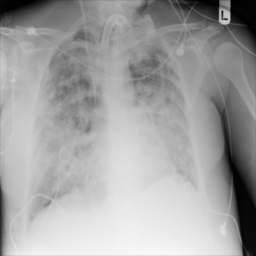

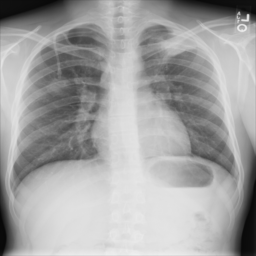

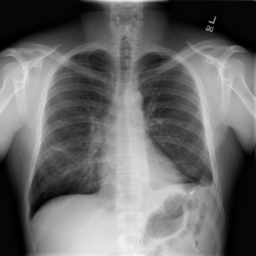

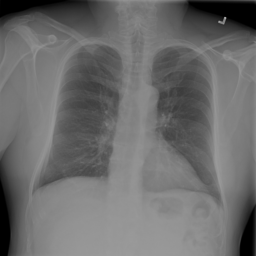

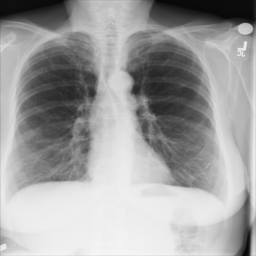

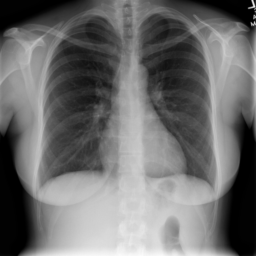

In [51]:
import os
import random
from IPython.display import Image, display

# Liste de chemins vers tes dossiers (paths)
paths = [
    "DATA/train/sain",
    "DATA/train/malade",
    "DATA/valid/sain",
    "DATA/valid/malade",
]

# Récupère tous les fichiers .png dans les dossiers
toutes_les_images = []
for path in paths:
    if os.path.exists(path):
        images = [os.path.join(path, f) for f in os.listdir(path) if f.lower().endswith('.png')]
        toutes_les_images.extend(images)

# Choisir un certain nombre d'images aléatoires (par exemple 6)
nombre_images = 6
images_choisies = random.sample(toutes_les_images, min(nombre_images, len(toutes_les_images)))

# Affiche les images dans le notebook
for chemin in images_choisies:
    display(Image(filename=chemin))


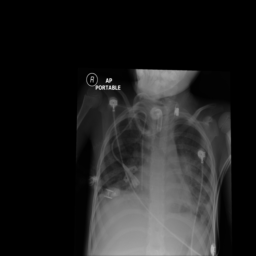

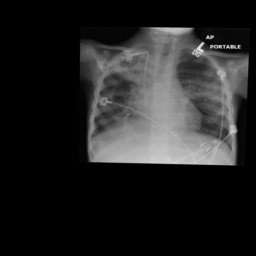

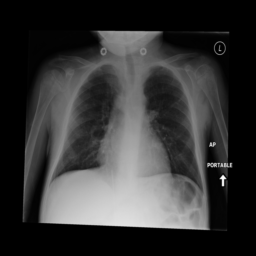

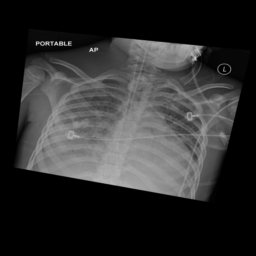

In [ ]:
from PIL import Image
from IPython.display import Image as IPImage, display

# Fonction pour calculer la luminosité moyenne d'une image
def calculer_luminosite(image_path):
    # Ouvrir l'image
    img = Image.open(image_path)
    
    # Convertir l'image en niveaux de gris (pour analyser la luminosité)
    grayscale_img = img.convert("L")
    
    # Convertir l'image en un tableau numpy
    img_array = np.array(grayscale_img)
    
    # Calculer la luminosité moyenne de l'image
    luminosite_moyenne = np.mean(img_array)
    
    return luminosite_moyenne

# Fonction pour récupérer toutes les images dans un répertoire
def recuperer_images_du_repertoire(dossier):
    images = []
    for file in os.listdir(dossier):
        if file.lower().endswith('.png'):  # Seulement les fichiers .png
            images.append(os.path.join(dossier, file))
    return images

# Variable pour stocker les images à faible luminosité
images_faible_luminosite = []

# Pour chaque dossier, récupérer toutes les images et choisir celle ayant la plus faible luminosité
for path in paths:
    if os.path.exists(path):
        # Récupérer toutes les images du dossier
        images = recuperer_images_du_repertoire(path)
        
        if images:
            # Calculer la luminosité pour chaque image
            luminosites = [(image, calculer_luminosite(image)) for image in images]
            
            # Trouver l'image avec la luminosité la plus faible
            image_min_luminosite = min(luminosites, key=lambda x: x[1])
            
            # Ajouter l'image à faible luminosité à la liste
            images_faible_luminosite.append(image_min_luminosite[0])

# Affichage des images à faible luminosité
for chemin in images_faible_luminosite:
    display(IPImage(filename=chemin))


In [57]:
import os
import numpy as np
import pandas as pd
from PIL import Image

def foreground_filter(gris, threshold):
    """
    Retourne un masque booléen indiquant quels pixels de l'image en niveaux de gris (gris)
    ont une valeur inférieure au seuil.
    """
    return gris < threshold

def lightness(img: Image.Image) -> float:
    """
    Calcule la "faible luminosité" d'une image PIL.
    L'image est convertie en niveaux de gris par la moyenne des canaux R, G et B.
    La fonction retourne la moyenne des pixels du premier plan (où la luminosité est inférieure au seuil).
    """
    M = np.array(img)
    
    gris = np.mean(M, axis=2)
    
    F = foreground_filter(gris, 130)
    
    if np.any(F):
        return np.mean(gris[F])
    else:
        return np.mean(gris)

paths = [
    "DATA/train/sain",
    "DATA/train/malade",
    "DATA/valid/sain",
    "DATA/valid/malade",
]

data = []

for dossier in paths:
    if os.path.exists(dossier):
        image_files = [os.path.join(dossier, f) for f in os.listdir(dossier) if f.lower().endswith('.png')]
        
        for image_path in image_files:
            with Image.open(image_path) as img:
                lum = lightness(img)
            data.append({
                "Image Index": os.path.basename(image_path),
                "Folder": dossier,
                "lightness": lum
            })

df = pd.DataFrame(data)
df.to_csv("lightness.csv", index=False)
print(df)


            Image Index             Folder  lightness
0      00000013_000.png    DATA/train/sain  97.578176
1      00000013_008.png    DATA/train/sain  73.399978
2      00000013_014.png    DATA/train/sain  99.117650
3      00000013_015.png    DATA/train/sain  97.846825
4      00000013_016.png    DATA/train/sain  99.206914
...                 ...                ...        ...
10943  00030370_003.png  DATA/valid/malade  71.391233
10944  00030370_004.png  DATA/valid/malade  90.396833
10945  00030370_005.png  DATA/valid/malade  73.081765
10946  00030370_006.png  DATA/valid/malade  70.979308
10947  00030733_002.png  DATA/valid/malade  64.723271

[10948 rows x 3 columns]


### Préparation du dataset AIF360

In [35]:
# Encodage sous format AIF360

protected_attributes = ['Patient Gender', 'age_30_65']
protected_attribute = protected_attributes[1]

def get_aif360_data(df):
    dff = df.copy()
    dff["Patient Gender"] = dff["Patient Gender"].map({"M": 0, "F": 1})

    ret_df = BinaryLabelDataset(
        favorable_label=0,  # "sain" est la classe favorable
        unfavorable_label=1,  # "malade" est la classe défavorable
        df=dff,
        label_names=['labels'], 
        protected_attribute_names=protected_attributes
    )

    ret_df_train = BinaryLabelDataset(
        favorable_label=0,  # "sain" est la classe favorable
        unfavorable_label=1,  # "malade" est la classe défavorable
        df=dff[dff["in_train"]==1],
        label_names=['labels'], 
        protected_attribute_names=protected_attributes
    )

    ret_df_valid = BinaryLabelDataset(
        favorable_label=0,  # "sain" est la classe favorable
        unfavorable_label=1,  # "malade" est la classe défavorable
        df=dff[dff["in_train"]==0],
        label_names=['labels'], 
        protected_attribute_names=protected_attributes
    )

    return ret_df, ret_df_train, ret_df_valid

aif_df, aif_df_train, aif_df_valid = get_aif360_data(df_encoded_bool)

aif_df

               instance weights    features                         \
                                                                     
                                Follow-up # Patient ID Patient Age   
instance names                                                       
0                           1.0         0.0       28.0        63.0   
1                           1.0         0.0       37.0        72.0   
2                           1.0         0.0       44.0        79.0   
3                           1.0         1.0       44.0        78.0   
4                           1.0         2.0       44.0        78.0   
...                         ...         ...        ...         ...   
5305                        1.0         0.0    30739.0        38.0   
5306                        1.0         0.0    30745.0        56.0   
5307                        1.0         0.0    30748.0        59.0   
5308                        1.0         0.0    30775.0        20.0   
5309                

In [36]:
def print_metrics(labels, preds=None, gender_or_age=0):
    if gender_or_age == 0:
        print("PROTECTED: Patient Gender")
        metrics_before_training = get_group_metrics(
            y_true=labels,
            y_pred=preds,
            prot_attr=aif_df_valid.protected_attributes[:, 0],
            priv_group=1,
            pos_label=0
        )

        # Affichage des résultats
        for metric, value in metrics_before_training.items():
            print(f"{metric}: {value:.4f}")
    else:
        print("PROTECTED: age_30_65")
        metrics_before_training = get_group_metrics(
            y_true=labels,
            y_pred=preds,
            prot_attr=aif_df_valid.protected_attributes[:, 1],
            priv_group=1,
            pos_label=0
        )

        # Affichage des résultats
        for metric, value in metrics_before_training.items():
            print(f"{metric}: {value:.4f}")

In [37]:
def get_test_Ys(csv_path):
    df = pd.read_csv(csv_path)
    train_test_split(df)
    df["preds"] = df["preds"].map({"sain": 0, "malade": 1}) 
    df["labels"] = df["labels"].map({"sain": 0, "malade": 1})
    test_df = df[df["in_train"] == 0]
    preds = test_df["preds"]
    labels= test_df["labels"]
    return labels, preds

labels, preds = get_test_Ys(PREDS_DIR+"/preds.csv")

print_metrics(labels, gender_or_age=0)
print("====================")
print_metrics(labels, gender_or_age=1)

# Explication des sorties:




PROTECTED: Patient Gender
base_rate: 0.5209
statistical_parity_difference: -0.0991
disparate_impact_ratio: 0.8285
PROTECTED: age_30_65
base_rate: 0.5209
statistical_parity_difference: 0.0344
disparate_impact_ratio: 1.0674


In [38]:
print_metrics(labels, preds, gender_or_age=0)
print("====================")
print_metrics(labels, preds, gender_or_age=1)

# Explication des sorties:


# -> On se concentre plus sur l'age

PROTECTED: Patient Gender
base_rate: 0.5209
statistical_parity_difference: 0.0028
disparate_impact_ratio: 1.0048
equal_opportunity_difference: 0.0988
average_odds_difference: 0.0270
conditional_demographic_disparity: -0.0004
smoothed_edf: 0.0065
df_bias_amplification: -0.2041
PROTECTED: age_30_65
base_rate: 0.5209
statistical_parity_difference: -0.1065
disparate_impact_ratio: 0.8250
equal_opportunity_difference: -0.1084
average_odds_difference: -0.1173
conditional_demographic_disparity: -0.0322
smoothed_edf: 0.2403
df_bias_amplification: 0.1679


In [39]:
y_true = df_encoded_bool["labels"]
y_pred = df_encoded_bool["preds"]
plot_confusion_matrix(y_true, y_pred, normalize=True)

# Explication des sorties:




In [40]:
plot_confusion_matrix_by_group(y_true, y_pred, df_encoded_bool, group_columns=["age_30_65"], labels=["sain", "malade"], normalize=True)

# Explication des sorties:




Matrice de confusion pour ['age_30_65']: (0,)


Matrice de confusion pour ['age_30_65']: (1,)


## II.3. Identification des biais

#### Résumé des biais identifiés précédemment:
**a. Une sous-représentation des femmes dans le dataset:**
*42% de femmes versus 58% d'hommes, n'est pas une grande différence, de plus, le disparate impact ratio (DIR)
est très proche de 1 dans tous les cas, ce qui indique qu'il n’y a pas de biais significatif en termes de différence de traitement entre les hommes et les femmes.*

**b. Une sous-représentation de quelques maladies dans le dataset (deséquilibre label):**
*On remarque que quelques maladies sont sous-représentées (exemple: Hernia, Fibrosis, ...), d'autres sont sur-représentées (exemple: Infiltration, Iffusion, ...), cela peut entraîner un biais, car le modèle peut par exemple toujours prédire qu'un patient n'a pas Hernia (par exemple), sans être vraiment pénalisé, et donc ça peut donner de faux scores élevés.*

**c. Une sous-représentation de quelques classes d'age:**
*De même, dû à la sous-représentation des classes d'âge jeunes et vieilles, un modèle entrainé sur ce dataset peut donner des prédictions meilleures pour la classe du mileu [30-65 ans].*

**d. Des anomalies liées à la distribution de patient_id:**
*L'anomalie qu'on a dans la distribution des Patient IDs au voisinage de l'ID 25000 (probablement dûe à des données manquantes), peut donner un modèle qui répond toujours par 'is_ill = 0' (Patient n'est pas malade), si l'ID du patient est dans le voisinage de 25000, qui pose un problème.*

---

## III. Application des méthodes de preprocessing

### a. Reweighing

In [41]:
# On applique le Reweighing sur le dataset
RW = Reweighing(unprivileged_groups=[{protected_attribute: 0}], privileged_groups=[{protected_attribute: 1}])
RW.fit(aif_df_train)
transformed_dataset_RW = RW.transform(aif_df)

df_encoded_bool["WEIGHTS"] = transformed_dataset_RW.instance_weights

# On reconcatène les colonnes relatives aux images
df_concatenated = pd.concat([df_image_related, df_encoded_bool], axis=1)

# On écrit les poids dans les metadatas
path_to_csv_RW = DATA_DIR+"/metadata_RW.csv"
df_concatenated.to_csv(path_to_csv_RW, index=False)


# On entraine le modele sur ces données (voir training.ipynb) -> resultat: preds_RW.csv


# On charge les prédictions
path_to_preds_RW = PREDS_DIR+"/preds_RW.csv"
labels, preds = get_test_Ys(path_to_preds_RW)

print_metrics(labels, preds, gender_or_age=0)
print("====================")
print_metrics(labels, preds, gender_or_age=1)

# Explication des sorties:




PROTECTED: Patient Gender
base_rate: 0.5209
statistical_parity_difference: -0.1014
disparate_impact_ratio: 0.8483
equal_opportunity_difference: 0.0111
average_odds_difference: -0.0842
conditional_demographic_disparity: 0.0159
smoothed_edf: 0.2660
df_bias_amplification: 0.0554
PROTECTED: age_30_65
base_rate: 0.5209
statistical_parity_difference: -0.1086
disparate_impact_ratio: 0.8319
equal_opportunity_difference: -0.0977
average_odds_difference: -0.1188
conditional_demographic_disparity: -0.0338
smoothed_edf: 0.2675
df_bias_amplification: 0.1951


### b. DisparateImpactRemover

In [42]:
# On applique le DIR sur le dataset
DIR = DisparateImpactRemover(sensitive_attribute=protected_attribute,repair_level=1.0)
transformed_dataset_DIR = DIR.fit_transform(aif_df)

# On reconcatène les colonnes relatives aux images
df_concatenated = pd.concat([df_image_related.reset_index(drop=True), 
    transformed_dataset_DIR.convert_to_dataframe()[0].reset_index(drop=True)], axis=1)

# On écrit les poids dans les metadatas
path_to_csv_DIR = DATA_DIR+"/metadata_DIR.csv"
df_concatenated.to_csv(path_to_csv_DIR, index=False)


# On entraine le modele sur ces données (voir training.ipynb) -> resultat: preds_DIR.csv


# On charge les prédictions
path_to_preds_DIR = PREDS_DIR+"/preds_DIR.csv"
labels, preds = get_test_Ys(path_to_preds_DIR)

print_metrics(labels, preds, gender_or_age=0)
print("====================")
print_metrics(labels, preds, gender_or_age=1)

# Explication des sorties:




PROTECTED: Patient Gender
base_rate: 0.5209
statistical_parity_difference: -0.1300
disparate_impact_ratio: 0.8128
equal_opportunity_difference: -0.0350
average_odds_difference: -0.1079
conditional_demographic_disparity: 0.0206
smoothed_edf: 0.3539
df_bias_amplification: 0.1433
PROTECTED: age_30_65
base_rate: 0.5209
statistical_parity_difference: -0.1107
disparate_impact_ratio: 0.8313
equal_opportunity_difference: -0.1328
average_odds_difference: -0.1199
conditional_demographic_disparity: -0.0347
smoothed_edf: 0.2792
df_bias_amplification: 0.2068


### c. LFR

In [43]:
# On applique le LFR sur le dataset
LFR = LFR(
    unprivileged_groups=[{protected_attribute: 0}],
    privileged_groups=[{protected_attribute: 1}],
    k=5,
    Ax=0.01,
    Ay=1.0,
    Az=50.0,
    print_interval=250,
    verbose=1,
    seed=None,
)
LFR.fit(aif_df_train, maxiter=5000, maxfun=5000)
transformed_dataset = LFR.transform(aif_df)

# On reconcatène les colonnes relatives aux images
df_concatenated = pd.concat([df_image_related.reset_index(drop=True), 
    transformed_dataset_DIR.convert_to_dataframe()[0].reset_index(drop=True)], axis=1)

# On écrit les poids dans les metadatas
path_to_csv_LFR = DATA_DIR+"/metadata_LFR.csv"
df_concatenated.to_csv(path_to_csv_LFR, index=False)


# On entraine le modele sur ces données (voir training.ipynb) -> resultat: preds_DIR.csv


# On charge les prédictions
path_to_preds_LFR = PREDS_DIR+"/preds_LFR.csv"
labels, preds = get_test_Ys(path_to_preds_LFR)

print_metrics(labels, preds, gender_or_age=0)
print("====================")
print_metrics(labels, preds, gender_or_age=1)

# Explication des sorties:




step: 0, loss: 630406.5150567994, L_x: 63040582.300278366,  L_y: 0.6844366954942793,  L_z: 0.0001523464044253242


step: 250, loss: 624308.907345617, L_x: 62428839.524372384,  L_y: 20.43871428520795,  L_z: 0.001467752156762848
step: 500, loss: 624308.9073456171, L_x: 62428839.524372414,  L_y: 20.438714285196376,  L_z: 0.0014677521567812515
step: 750, loss: 624310.3125690399, L_x: 62430701.01229501,  L_y: 3.2290595106565148,  L_z: 0.0014677315823634868
step: 1000, loss: 624294.6995010055, L_x: 62429056.87264541,  L_y: 4.057387056671073,  L_z: 0.0014677498950252396
step: 1250, loss: 624269.9012391404, L_x: 62426431.045336634,  L_y: 5.517397025758148,  L_z: 0.0014677749669437538
step: 1500, loss: 523952.02583369764, L_x: 52395032.014547236,  L_y: 1.2726184552028676,  L_z: 0.008661395401389431
step: 1750, loss: 301735.241899992, L_x: 30172108.848396968,  L_y: 13.592421657191514,  L_z: 0.011219887302896818
step: 2000, loss: 51167.44997457593, L_x: 5115188.190816842,  L_y: 14.50743436416496,  L_z: 0.021212640866906586
step: 2250, loss: 28631.126665280543, L_x: 2861423.9709041943,  L_y: 15.081124178609754

---

## IV. Application des méthodes de postprocessing

### a. Equalized Odds

In [44]:
from aif360.algorithms.postprocessing import EqOddsPostprocessing
from sklearn.metrics import accuracy_score

# Initialisation de l'algorithme Equalized Odds Postprocessing
eq_odds = EqOddsPostprocessing(
    unprivileged_groups=[{protected_attribute: 0}],
    privileged_groups=[{protected_attribute: 1}],
    seed=42
)

# Ajustement des prédictions sur le dataset de validation
eq_odds.fit(aif_df_valid, aif_df_valid)

# Transformation des prédictions
transformed_eq_odds = eq_odds.predict(aif_df_valid)

# Calcul des métriques après post-traitement
print("Metrics after Equalized Odds Postprocessing:")
print_metrics(
    labels=aif_df_valid.labels.ravel(),
    preds=transformed_eq_odds.labels.ravel(),
    gender_or_age=1  # 0 pour 'Patient Gender', 1 pour 'age_30_65'
)

# Évaluation des performances
accuracy = accuracy_score(aif_df_valid.labels, transformed_eq_odds.labels)
print(f"Accuracy after Equalized Odds Postprocessing: {accuracy:.4f}")

Metrics after Equalized Odds Postprocessing:
PROTECTED: age_30_65
base_rate: 0.5209
statistical_parity_difference: 0.0344
disparate_impact_ratio: 1.0674
equal_opportunity_difference: 0.0000
average_odds_difference: 0.0000
conditional_demographic_disparity: 0.0102
smoothed_edf: 0.0724
df_bias_amplification: 0.0000
Accuracy after Equalized Odds Postprocessing: 1.0000


In [45]:
# Matrice de confusion globale après Equalized Odds
plot_confusion_matrix(
    y_true=aif_df_valid.labels.ravel(),
    y_pred=transformed_eq_odds.labels.ravel(),
    normalize=True,
    title="Matrice de confusion après Equalized Odds"
)
"""
        
# Matrice de confusion par groupe (par exemple, age_30_65) après Equalized Odds
plot_confusion_matrix_by_group(
    y_true=aif_df_valid.labels.ravel(),
    y_pred=transformed_eq_odds.labels.ravel(),
    df=df_encoded_bool,
    group_columns=["age_30_65"],
    labels=["sain", "malade"],
    normalize=True
)"""

'\n\n# Matrice de confusion par groupe (par exemple, age_30_65) après Equalized Odds\nplot_confusion_matrix_by_group(\n    y_true=aif_df_valid.labels.ravel(),\n    y_pred=transformed_eq_odds.labels.ravel(),\n    df=df_encoded_bool,\n    group_columns=["age_30_65"],\n    labels=["sain", "malade"],\n    normalize=True\n)'

### b. Reject Option Classification

In [46]:
from aif360.algorithms.postprocessing import RejectOptionClassification

# Calcul des métriques avant l'application de Reject Option Classification
print("Metrics before Reject Option Classification:")
print_metrics(
    labels=aif_df_valid.labels.ravel(),
    preds=aif_df_valid.scores.ravel(),  # Utilisation des scores bruts avant post-traitement
    gender_or_age=1  # 0 pour 'Patient Gender', 1 pour 'age_30_65'
)

# Évaluation des performances avant post-traitement
accuracy_before = accuracy_score(aif_df_valid.labels, (aif_df_valid.scores > 0.5).astype(int))
print(f"Accuracy before Reject Option Classification: {accuracy_before:.4f}")



Metrics before Reject Option Classification:
PROTECTED: age_30_65
base_rate: 0.5209
statistical_parity_difference: -0.0344
disparate_impact_ratio: 0.9300
equal_opportunity_difference: 0.0000
average_odds_difference: 0.0000
conditional_demographic_disparity: -0.0102
smoothed_edf: 0.0724
df_bias_amplification: 0.0000
Accuracy before Reject Option Classification: 0.0000


In [47]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from aif360.algorithms.postprocessing import RejectOptionClassification
from aif360.datasets import BinaryLabelDataset
from sklearn.metrics import accuracy_score

# 1. Charger le fichier CSV
df = pd.read_csv('data.csv')  # Remplace par ton chemin de fichier

# Supposons que 'features' soit une colonne avec les caractéristiques d'entrée
# 'labels' sont les étiquettes cibles et 'protected_attribute' est l'attribut protégé
X = df.drop(['labels', 'protected_attribute'], axis=1).values
y = df['labels'].values
protected_attribute = df['protected_attribute'].values

# Normaliser les données (si nécessaire)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 2. Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test, protected_train, protected_test = train_test_split(X, y, protected_attribute, test_size=0.2, random_state=42)

# Convertir en tensors PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# 3. Définir un modèle simple (MLP ici, mais tu peux choisir un autre modèle)
class SimpleModel(nn.Module):
    def __init__(self, input_size):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)  # Classification binaire
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 4. Entraîner le modèle
model = SimpleModel(X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraînement
for epoch in range(100):  # Nombre d'epochs
    model.train()
    optimizer.zero_grad()
    
    # Passage avant
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Rétropropagation
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/100], Loss: {loss.item():.4f}')

# 5. Prédictions sur le test
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)

# 6. Calculer l'exactitude avant application de ROC
accuracy_before_roc = accuracy_score(y_test, predicted.numpy())
print(f'Accuracy before ROC: {accuracy_before_roc:.4f}')

# 7. Préparer les données pour l'application du Reject Option Classification (ROC)
# Créer un dataset BinaryLabelDataset à partir des données
test_data = pd.DataFrame(X_test, columns=[f'feature_{i}' for i in range(X_test.shape[1])])
test_data['labels'] = y_test
test_data['protected_attribute'] = protected_test

# Convertir en un format utilisable par aif360
aif_test_data = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=test_data,
    label_names=['labels'],
    protected_attribute_names=['protected_attribute']
)

# 8. Appliquer Reject Option Classification (ROC)
roc = RejectOptionClassification(
    unprivileged_groups=[{'protected_attribute': 0}],
    privileged_groups=[{'protected_attribute': 1}],
    low_class_thresh=0.01,
    high_class_thresh=0.99,
    num_class_thresh=100,
    num_ROC_margin=50,
    metric_name="Statistical parity difference",
    metric_ub=0.05,
    metric_lb=-0.05
)

# Ajuster les prédictions à l'aide de ROC
roc.fit(aif_test_data, predicted.numpy())
transformed_roc = roc.predict(aif_test_data)

# 9. Calculer l'exactitude après application de ROC
transformed_predicted = transformed_roc.labels
accuracy_after_roc = accuracy_score(y_test, transformed_predicted)
print(f'Accuracy after ROC: {accuracy_after_roc:.4f}')


FileNotFoundError: [Errno 2] No such file or directory: 'data.csv'

In [ ]:
path_to_preds_DIR = PREDS_DIR+"/preds.csv"
labels, preds = get_test_Ys(path_to_preds_DIR)


In [ ]:

# Initialisation de l'algorithme Reject Option Classification
roc = RejectOptionClassification(
    unprivileged_groups=[{protected_attribute: 0}],
    privileged_groups=[{protected_attribute: 1}],
    low_class_thresh=0.01,
    high_class_thresh=0.99,
    num_class_thresh=100,
    num_ROC_margin=50,
    metric_name="Statistical parity difference",
    metric_ub=0.05,
    metric_lb=-0.05,
)

# Ajustement des prédictions sur le dataset de validation
roc.fit(aif_df_valid, QueFaire)

# Transformation des prédictions
transformed_roc = roc.predict(aif_df_valid)

# Calcul des métriques après post-traitement
print("Metrics after Reject Option Classification:")
print_metrics(
    labels=aif_df_valid.labels.ravel(),
    preds=transformed_roc.labels.ravel(),
    gender_or_age=1  # 0 pour 'Patient Gender', 1 pour 'age_30_65'
)

# Évaluation des performances
accuracy = accuracy_score(aif_df_valid.labels, transformed_roc.labels)
print(f"Accuracy after Reject Option Classification: {accuracy:.4f}")

TypeError: NDFrame.copy() got an unexpected keyword argument 'deepcopy'

In [ ]:
# Matrice de confusion globale après Reject Option Classification
plot_confusion_matrix(
    y_true=aif_df_valid.labels.ravel(),
    y_pred=transformed_roc.labels.ravel(),
    normalize=True,
    title="Matrice de confusion après Reject Option Classification"
)

"""# Matrice de confusion par groupe (par exemple, age_30_65) après Reject Option Classification
plot_confusion_matrix_by_group(
    y_true=aif_df_valid.labels.ravel(),
    y_pred=transformed_roc.labels.ravel(),
    df=df_encoded_bool,
    group_columns=["age_30_65"],
    labels=["sain", "malade"],
    normalize=True
)"""

'# Matrice de confusion par groupe (par exemple, age_30_65) après Reject Option Classification\nplot_confusion_matrix_by_group(\n    y_true=aif_df_valid.labels.ravel(),\n    y_pred=transformed_roc.labels.ravel(),\n    df=df_encoded_bool,\n    group_columns=["age_30_65"],\n    labels=["sain", "malade"],\n    normalize=True\n)'

### c. Calibrated Equalized Odds

In [ ]:
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing

# Initialisation
calibrated_eq_odds = CalibratedEqOddsPostprocessing(
    unprivileged_groups=[{protected_attribute: 0}],
    privileged_groups=[{protected_attribute: 1}],
    cost_constraint="fnr",  # ou "fpr", ou "weighted"
    seed=42
)

# Ajustement des prédictions
calibrated_eq_odds.fit(aif_df_valid, aif_df_valid)

# Transformation des prédictions
transformed_calibrated_eq_odds = calibrated_eq_odds.predict(aif_df_valid)

# Calcul des métriques
print("Metrics after Calibrated Equalized Odds Postprocessing:")
print_metrics(
    labels=aif_df_valid.labels.ravel(),
    preds=transformed_calibrated_eq_odds.labels.ravel(),
    gender_or_age=1
)

Metrics after Calibrated Equalized Odds Postprocessing:
PROTECTED: age_30_65
base_rate: 0.5209
statistical_parity_difference: 0.0344
disparate_impact_ratio: 1.0674
equal_opportunity_difference: 0.0000
average_odds_difference: 0.0000
conditional_demographic_disparity: 0.0102
smoothed_edf: 0.0724
df_bias_amplification: 0.0000


---

## V. Analyse et compréhension

### -> Get together and link preproc and postproc results

---

## VI. Conclusion

### *Preferably*, get together and discuss final comments